## Stock Price Prediction

In this case study I will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

## 1. Problem definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


## 2. Loading data

In [ ]:
# pip install all the required packages
pip install yfinance

SyntaxError: invalid syntax (2889815480.py, line 2)

In [13]:
# Load libraries
import numpy as np
import pandas as pd
import yfinance as yfin
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [14]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# extract the data required
import datetime as dt
start = dt.datetime(2018,1,2) #start date
end = dt.datetime(2022,12,29) #end date

import yfinance as yf

# Define tickers
stk_tickers = ['AAPL','MSFT','AMZN','TSLA','GOOG']

# For currencies, use Yahoo Finance format
ccy_tickers = ['JPY=X', 'GBPUSD=X']  # USD/JPY and GBP/USD

# For indices, use Yahoo Finance format
idx_tickers = ['^GSPC', '^DJI', '^VIX']  # S&P 500, Dow Jones, VIX

# Download all data
stk_data = yf.download(stk_tickers, start=start, end=end)
ccy_data = yf.download(ccy_tickers, start=start, end=end)
idx_data = yf.download(idx_tickers, start=start, end=end)

print("Stock data shape:", stk_data.shape)
print("Currency data shape:", ccy_data.shape)
print("Index data shape:", idx_data.shape)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed

Stock data shape: (1257, 25)
Currency data shape: (1301, 10)
Index data shape: (1257, 15)


In [16]:
# Set the return period to 5 business days (weekly return)
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns   
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [ ]:
# Extract Close prices
stk_prices = stk_data['Close']
ccy_prices = ccy_data['Close'] 
idx_prices = idx_data['Close']

# Target variable: MSFT future returns
# 1.take natural log, 2.calculate return over return_period, 3.shift back by return_period
Y = np.log(stk_prices['MSFT']).diff(return_period).shift(-return_period)
Y.name = 'MSFT_pred' #before the name was 'MSFT', retrieved from column name

# Feature 1: Other stocks (don't need to shift as they are known at time t)
X1 = np.log(stk_prices[['GOOG', 'AAPL']]).diff(return_period)

# Feature 2: Currencies  
X2 = np.log(ccy_prices).diff(return_period)
X2.columns = ['JPY', 'GBP'] #change column names

# Feature 3: Indices
X3 = np.log(idx_prices).diff(return_period)
X3.columns = ['SP500', 'DJIA', 'VIX'] #change column names

# Feature 4: MSFT lagged returns(momemtum strategy)
# 1,3,6,12 weeks ago(MSFT's recent momentum)
X4 = pd.concat([
    np.log(stk_prices['MSFT']).diff(i) 
    for i in [return_period, return_period*3, return_period*6, return_period*12]
], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

# Combine all features
X = pd.concat([X1, X2, X3, X4], axis=1)

# Create final dataset
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :] #take every 5th row to avoid overlapping data
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

print("Dataset shape:", dataset.shape)
print("Y shape:", Y.shape)
print("X shape:", X.shape)
print("\nFirst few rows:")
print(dataset.head())

Dataset shape: (239, 12)
Y shape: (239,)
X shape: (239, 11)

First few rows:
            MSFT_pred      GOOG      AAPL       JPY       GBP     SP500  \
Date                                                                      
2018-03-29  -0.011460 -0.016618 -0.006357 -0.004671  0.008301  0.006043   
2018-04-06   0.031098 -0.024280  0.003570 -0.001472  0.005367 -0.007093   
2018-04-13   0.020418  0.021834  0.037019  0.016241  0.001587  0.017700   
2018-04-20   0.008594  0.041571 -0.052942 -0.010706  0.001957  0.004211   
2018-04-27  -0.006912 -0.040814 -0.020730 -0.011930  0.017238 -0.006223   

                DJIA       VIX   MSFT_DT  MSFT_3DT  MSFT_6DT  MSFT_12DT  
Date                                                                     
2018-03-29 -0.001067 -0.155938  0.016349 -0.034036  0.005053   0.064743  
2018-04-06 -0.013879  0.073357 -0.011460 -0.042846 -0.016488   0.027215  
2018-04-13  0.019705 -0.210543  0.031098  0.035986  0.002474   0.036782  
2018-04-20  0.005197 -0.030

## 3. Exploratory Data Analysis

In [21]:
dataset.describe()

,MSFT_pred,GOOG,AAPL,JPY,GBP,SP500,DJIA,VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.004183,0.002327,0.005106,-0.000623,0.001075,0.001334,0.001570,-0.000438,0.004437,0.013242,0.026026,0.051596
std,0.037516,0.041255,0.044678,0.014341,0.010495,0.029727,0.029395,0.168886,0.037438,0.057609,0.075255,0.099249
min,-0.178708,-0.168131,-0.165544,-0.097680,-0.050906,-0.208720,-0.198044,-0.447131,-0.178708,-0.282310,-0.228859,-0.245550
25%,-0.014567,-0.019407,-0.019257,-0.007775,-0.004756,-0.008346,-0.008933,-0.090368,-0.013355,-0.013363,-0.016192,-0.006782
50%,0.006081,0.005311,0.009344,-0.000333,0.000875,0.003889,0.004140,-0.026548,0.006188,0.019707,0.033266,0.064656
75%,0.026364,0.025502,0.032018,0.006897,0.006166,0.015786,0.016938,0.071194,0.026364,0.047618,0.078744,0.119920
max,0.089746,0.142634,0.162119,0.048802,0.035794,0.115749,0.098984,0.922952,0.089746,0.145979,0.227306,0.306231


In [22]:
dataset.head()

,MSFT_pred,GOOG,AAPL,JPY,GBP,SP500,DJIA,VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
Date,,,,,,,,,,,,
2018-03-29,-0.011460,-0.016618,-0.006357,-0.004671,0.008301,0.006043,-0.001067,-0.155938,0.016349,-0.034036,0.005053,0.064743
2018-04-06,0.031098,-0.024280,0.003570,-0.001472,0.005367,-0.007093,-0.013879,0.073357,-0.011460,-0.042846,-0.016488,0.027215
2018-04-13,0.020418,0.021834,0.037019,0.016241,0.001587,0.017700,0.019705,-0.210543,0.031098,0.035986,0.002474,0.036782
2018-04-20,0.008594,0.041571,-0.052942,-0.010706,0.001957,0.004211,0.005197,-0.030915,0.020418,0.040055,0.006018,0.038734
2018-04-27,-0.006912,-0.040814,-0.020730,-0.011930,0.017238,-0.006223,-0.000086,-0.091113,0.008594,0.060110,0.017263,0.013176


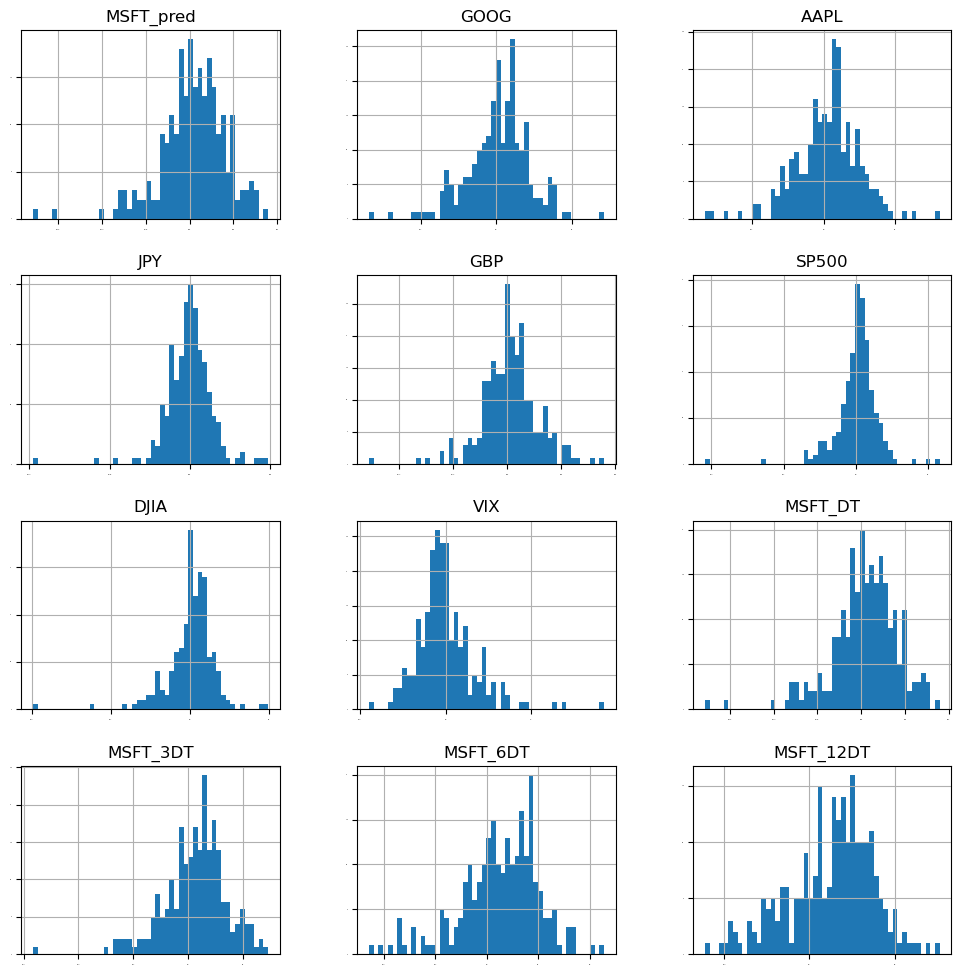

In [ ]:
#distribution of the data over the entire period
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()
#sharex and sharey set to false to have individual axis for each plot
# set labelsize small so that labels don't overlap

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

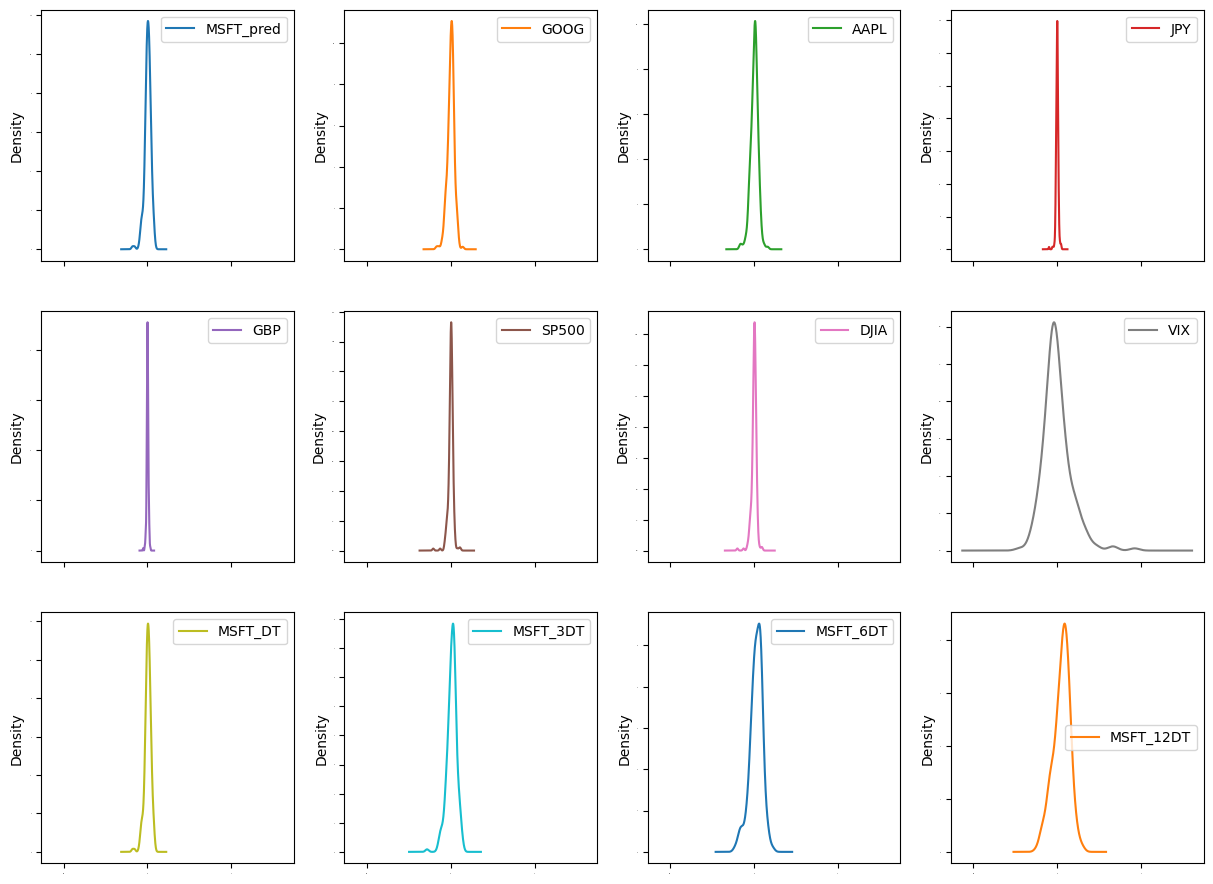

In [30]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that VIX has a much larger variance(wider interval) compared to the other distributions.
In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix.

<Axes: title={'center': 'Correlation Matrix'}>

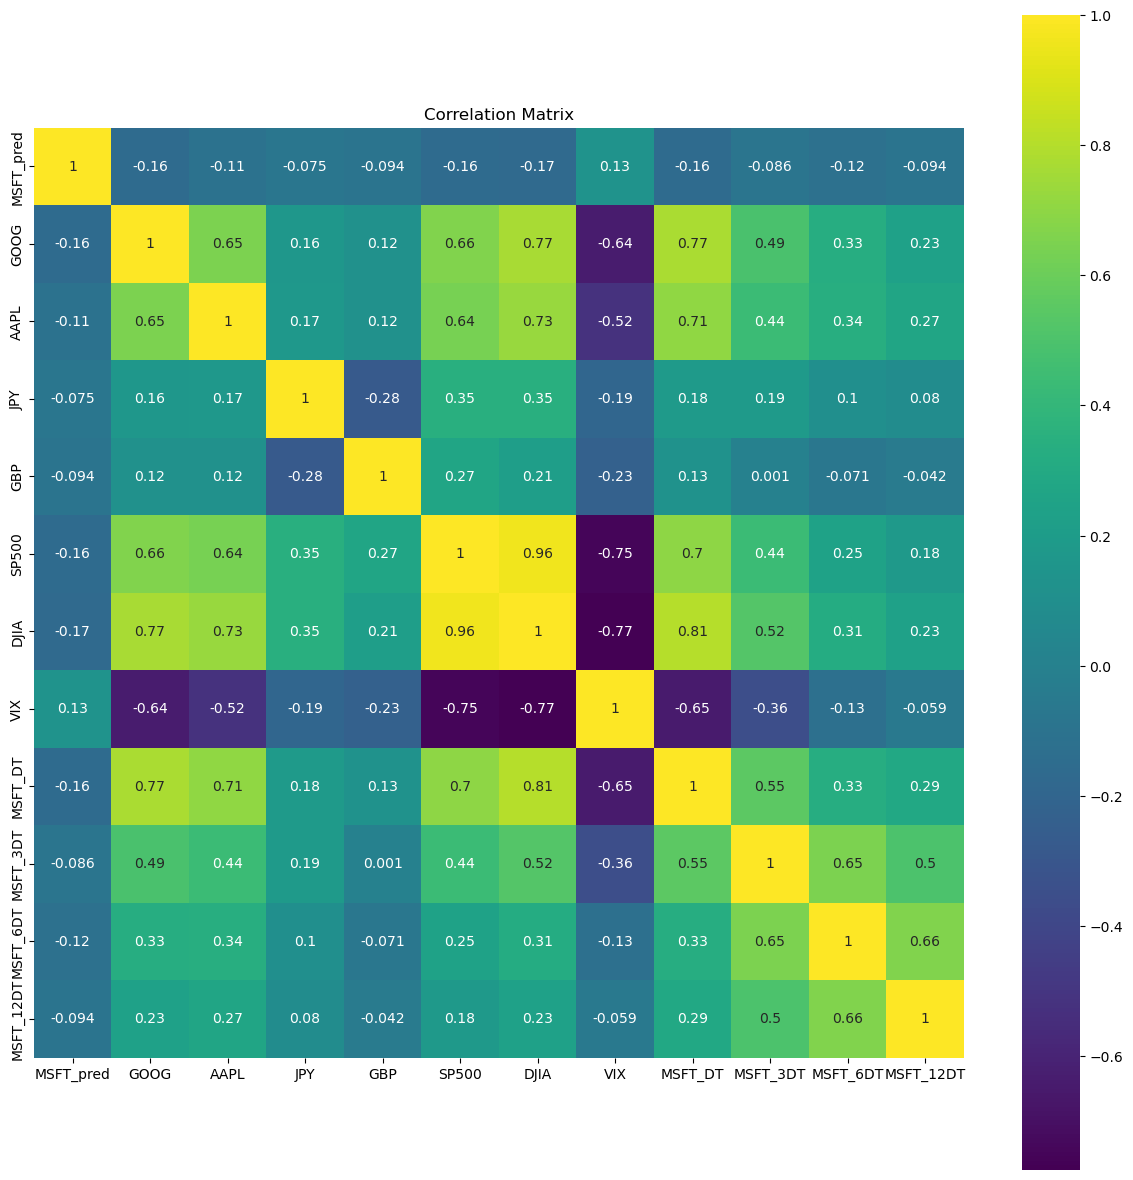

In [34]:
correlation=dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='viridis')

<Figure size 1500x1500 with 0 Axes>

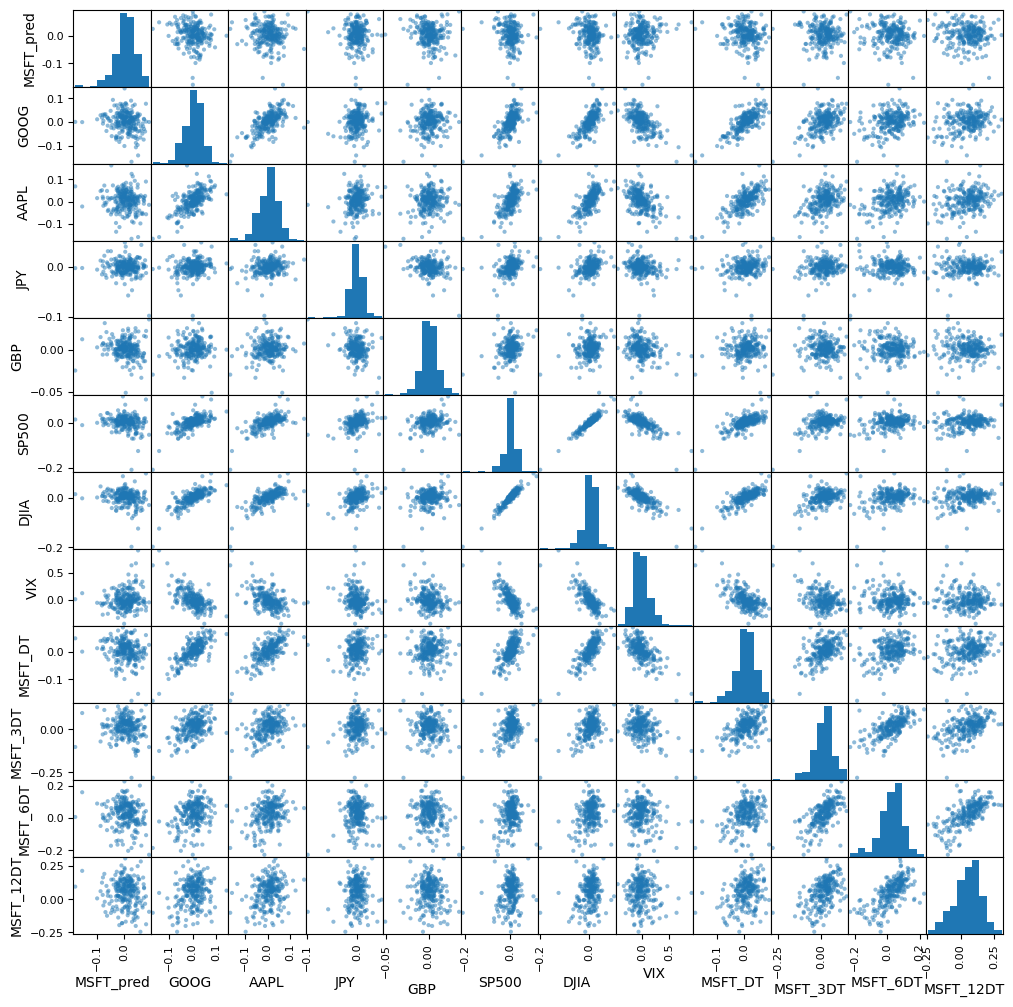

In [35]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

We see in distributions:
- Most variables are approximately normally distributed
- VIX is right skewed (might consider log transform)
- MSFT lagged returns get wider with time(makes sense)

We see in correlations:
- MSFT_pred<->GOOG,AAPL ; techstocks move together
- SP500<->DJIA ; Indices highly correlated(redundant feature)
- MSFT momentum features ; All MSFT lagged returns correlate with each other
- VIX and currencies have no/weak correlations


Now we will look at the time series analysis

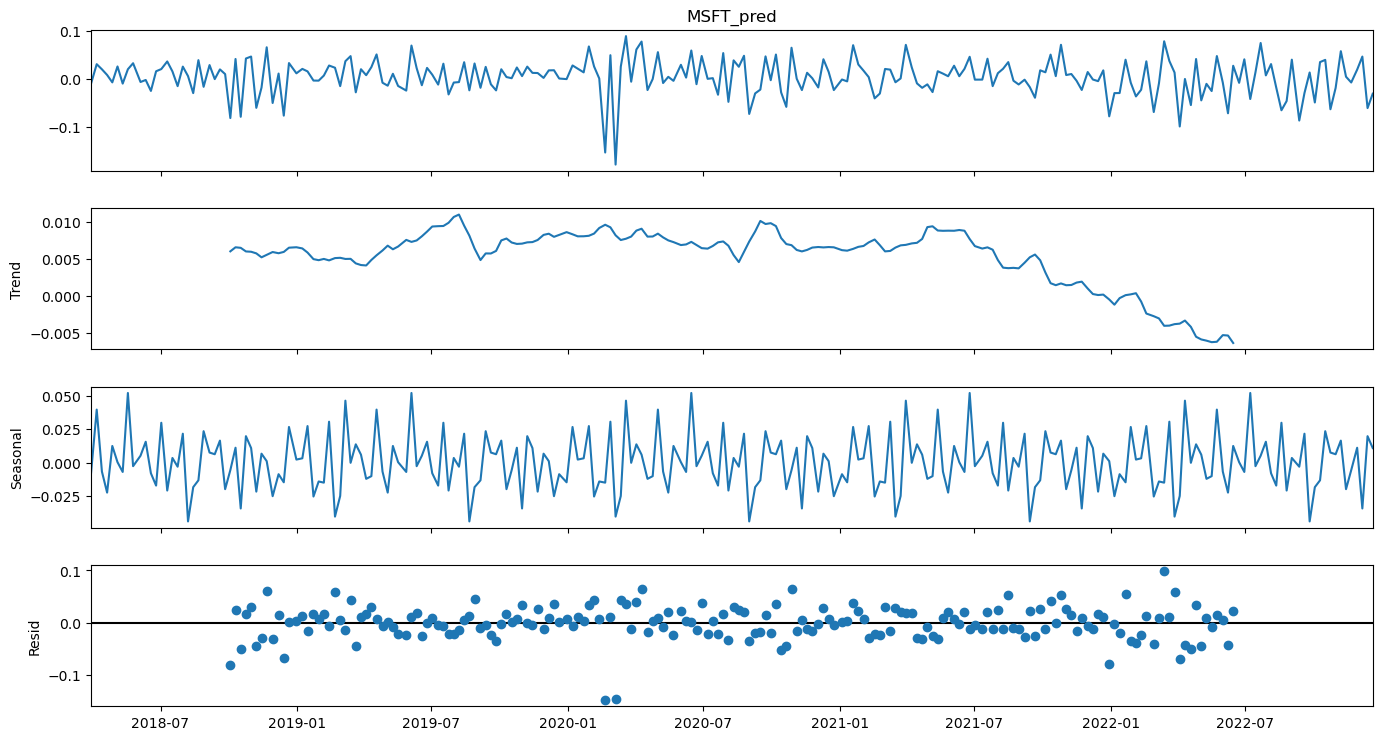

In [37]:
res=sm.tsa.seasonal_decompose(Y,period=52)
fig=res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

## 4. Data Preparation

Feature selection; I use 